<a href="https://colab.research.google.com/github/SumitDS23/Capstone-Project-34/blob/main/MVP_and_HRP_Portfolios_auto_Sector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP and HRP Portfolio Design for Auto Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [2]:
path="https://github.com/SumitDS23/Capstone-Project-34/raw/main/auto.csv"

In [3]:
# load dataset
dataset = read_csv(path,index_col=0)

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [6]:
# shape
dataset.shape

(991, 10)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head()

,M&M.NS,MARUTI.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,EICHERMOT.NS,HEROMOTOCO.NS,TIINDIA.NS,TVSMOTOR.NS,ASHOKLEY.NS,BHARATFORG.NS
2019-07-01,660.000000,6507.850098,168.000000,2911.949951,1962.530029,2616.500000,387.500000,435.549988,87.099998,457.600006
2019-07-02,666.250000,6560.000000,163.750000,2883.550049,2013.744995,2597.050049,389.600006,430.500000,87.849998,460.100006
2019-07-03,669.250000,6533.799805,162.300003,2897.750000,1965.010010,2587.500000,387.200012,435.000000,90.300003,462.750000
2019-07-04,672.150024,6544.450195,165.199997,2894.800049,1982.540039,2606.149902,386.700012,432.350006,89.949997,475.950012
2019-07-05,642.049988,6360.000000,160.199997,2842.550049,1964.510010,2512.300049,386.899994,424.299988,87.050003,458.100006


<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = False


(991, 10)

Getting rid of the columns with more than 30% missing values.

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(991, 10)

Given that there are null values drop the rown contianing the null values.

In [10]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head()

,M&M.NS,MARUTI.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,EICHERMOT.NS,HEROMOTOCO.NS,TIINDIA.NS,TVSMOTOR.NS,ASHOKLEY.NS,BHARATFORG.NS
2019-07-01,660.000000,6507.850098,168.000000,2911.949951,1962.530029,2616.500000,387.500000,435.549988,87.099998,457.600006
2019-07-02,666.250000,6560.000000,163.750000,2883.550049,2013.744995,2597.050049,389.600006,430.500000,87.849998,460.100006
2019-07-03,669.250000,6533.799805,162.300003,2897.750000,1965.010010,2587.500000,387.200012,435.000000,90.300003,462.750000
2019-07-04,672.150024,6544.450195,165.199997,2894.800049,1982.540039,2606.149902,386.700012,432.350006,89.949997,475.950012
2019-07-05,642.049988,6360.000000,160.199997,2842.550049,1964.510010,2512.300049,386.899994,424.299988,87.050003,458.100006


<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.35% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [11]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8335)

In [12]:
X_train = X.head(train_len)

In [13]:
X_train

,M&M.NS,MARUTI.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,EICHERMOT.NS,HEROMOTOCO.NS,TIINDIA.NS,TVSMOTOR.NS,ASHOKLEY.NS,BHARATFORG.NS
2019-07-01,660.000000,6507.850098,168.000000,2911.949951,1962.530029,2616.500000,387.500000,435.549988,87.099998,457.600006
2019-07-02,666.250000,6560.000000,163.750000,2883.550049,2013.744995,2597.050049,389.600006,430.500000,87.849998,460.100006
2019-07-03,669.250000,6533.799805,162.300003,2897.750000,1965.010010,2587.500000,387.200012,435.000000,90.300003,462.750000
2019-07-04,672.150024,6544.450195,165.199997,2894.800049,1982.540039,2606.149902,386.700012,432.350006,89.949997,475.950012
2019-07-05,642.049988,6360.000000,160.199997,2842.550049,1964.510010,2512.300049,386.899994,424.299988,87.050003,458.100006
...,...,...,...,...,...,...,...,...,...,...
2022-10-20,1250.000000,8707.400391,398.100006,3691.850098,3651.149902,2565.550049,2793.149902,1142.250000,144.750000,789.000000
2022-10-21,1256.750000,8703.299805,398.049988,3668.600098,3629.500000,2569.850098,2707.050049,1141.800049,143.000000,778.200012
2022-10-24,1270.949951,8765.450195,401.600006,3699.800049,3641.199951,2581.899902,2720.500000,1146.099976,144.550003,786.349976
2022-10-25,1281.400024,9005.000000,404.549988,3654.100098,3710.649902,2585.600098,2829.899902,1156.949951,147.250000,806.650024


In [14]:
X_test = X.tail(row-train_len)
X_test

,M&M.NS,MARUTI.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,EICHERMOT.NS,HEROMOTOCO.NS,TIINDIA.NS,TVSMOTOR.NS,ASHOKLEY.NS,BHARATFORG.NS
2022-10-28,1311.650024,9492.549805,409.899994,3670.699951,3745.750000,2649.850098,2668.300049,1127.150024,149.149994,833.150024
2022-10-31,1348.599976,9527.599609,412.750000,3671.850098,3850.449951,2676.850098,2743.250000,1146.050049,153.300003,834.200012
2022-11-01,1354.050049,9454.599609,421.350006,3732.699951,3798.399902,2673.149902,2797.800049,1138.000000,149.750000,850.700012
2022-11-02,1352.349976,9229.400391,422.149994,3736.800049,3729.199951,2643.949951,2843.449951,1115.000000,149.449997,847.200012
2022-11-03,1335.400024,9239.099609,416.250000,3773.500000,3675.250000,2646.350098,2866.600098,1134.650024,148.050003,857.200012
...,...,...,...,...,...,...,...,...,...,...
2023-06-22,1378.699951,9403.049805,569.349976,4612.100098,3558.600098,2825.050049,3220.449951,1326.150024,164.000000,814.950012
2023-06-23,1373.250000,9327.299805,559.650024,4622.600098,3539.199951,2776.399902,3164.050049,1301.250000,161.600006,807.000000
2023-06-26,1397.650024,9470.200195,567.849976,4606.899902,3551.649902,2851.250000,3195.699951,1290.349976,164.250000,815.299988
2023-06-27,1402.400024,9461.000000,573.099976,4618.049805,3535.750000,2844.100098,3134.199951,1304.199951,163.600006,819.750000


In [15]:
#Calculate percentage return
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

In [16]:
returns

,M&M.NS,MARUTI.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,EICHERMOT.NS,HEROMOTOCO.NS,TIINDIA.NS,TVSMOTOR.NS,ASHOKLEY.NS,BHARATFORG.NS
2019-07-02,0.009470,0.008013,-0.025298,-0.009753,0.026096,-0.007434,0.005419,-0.011595,0.008611,0.005463
2019-07-03,0.004503,-0.003994,-0.008855,0.004924,-0.024201,-0.003677,-0.006160,0.010453,0.027888,0.005760
2019-07-04,0.004333,0.001630,0.017868,-0.001018,0.008921,0.007208,-0.001291,-0.006092,-0.003876,0.028525
2019-07-05,-0.044782,-0.028184,-0.030266,-0.018050,-0.009094,-0.036011,0.000517,-0.018619,-0.032240,-0.037504
2019-07-08,-0.009657,-0.050519,-0.035268,-0.022779,-0.031163,-0.052601,-0.006074,-0.031110,-0.025847,-0.019537
...,...,...,...,...,...,...,...,...,...,...
2022-10-20,0.001282,-0.001370,-0.002381,0.009847,0.010755,0.009582,-0.013927,-0.024926,-0.014300,0.010049
2022-10-21,0.005400,-0.000471,-0.000126,-0.006298,-0.005930,0.001676,-0.030825,-0.000394,-0.012090,-0.013688
2022-10-24,0.011299,0.007141,0.008919,0.008505,0.003224,0.004689,0.004968,0.003766,0.010839,0.010473
2022-10-25,0.008222,0.027329,0.007346,-0.012352,0.019073,0.001433,0.040213,0.009467,0.018679,0.025816


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [17]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [18]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([3.        , 5.        , 0.59233509, 2.        ])

In [19]:
link.shape

(9, 4)

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

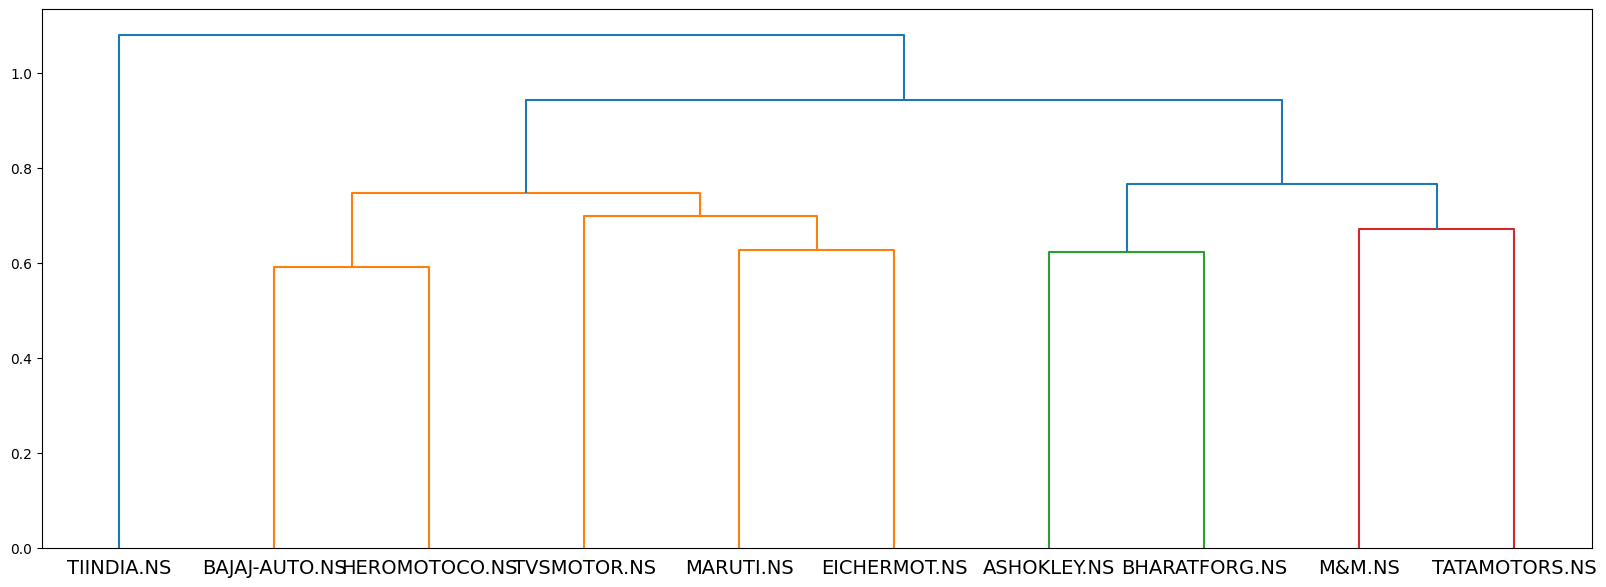

In [20]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [21]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [22]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [23]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)


    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [24]:
def get_all_portfolios(returns):

    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [25]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                    MVP       HRP
M&M.NS         0.071018  0.113031
MARUTI.NS      0.037504  0.075910
TATAMOTORS.NS  0.003022  0.055371
BAJAJ-AUTO.NS  0.415963  0.181625
EICHERMOT.NS   0.098945  0.125466
HEROMOTOCO.NS  0.088170  0.083688
TIINDIA.NS     0.205688  0.115769
TVSMOTOR.NS    0.057490  0.155773
ASHOKLEY.NS    0.004732  0.039462
BHARATFORG.NS  0.017467  0.053905


Text(0.5, 1.0, 'HRP')

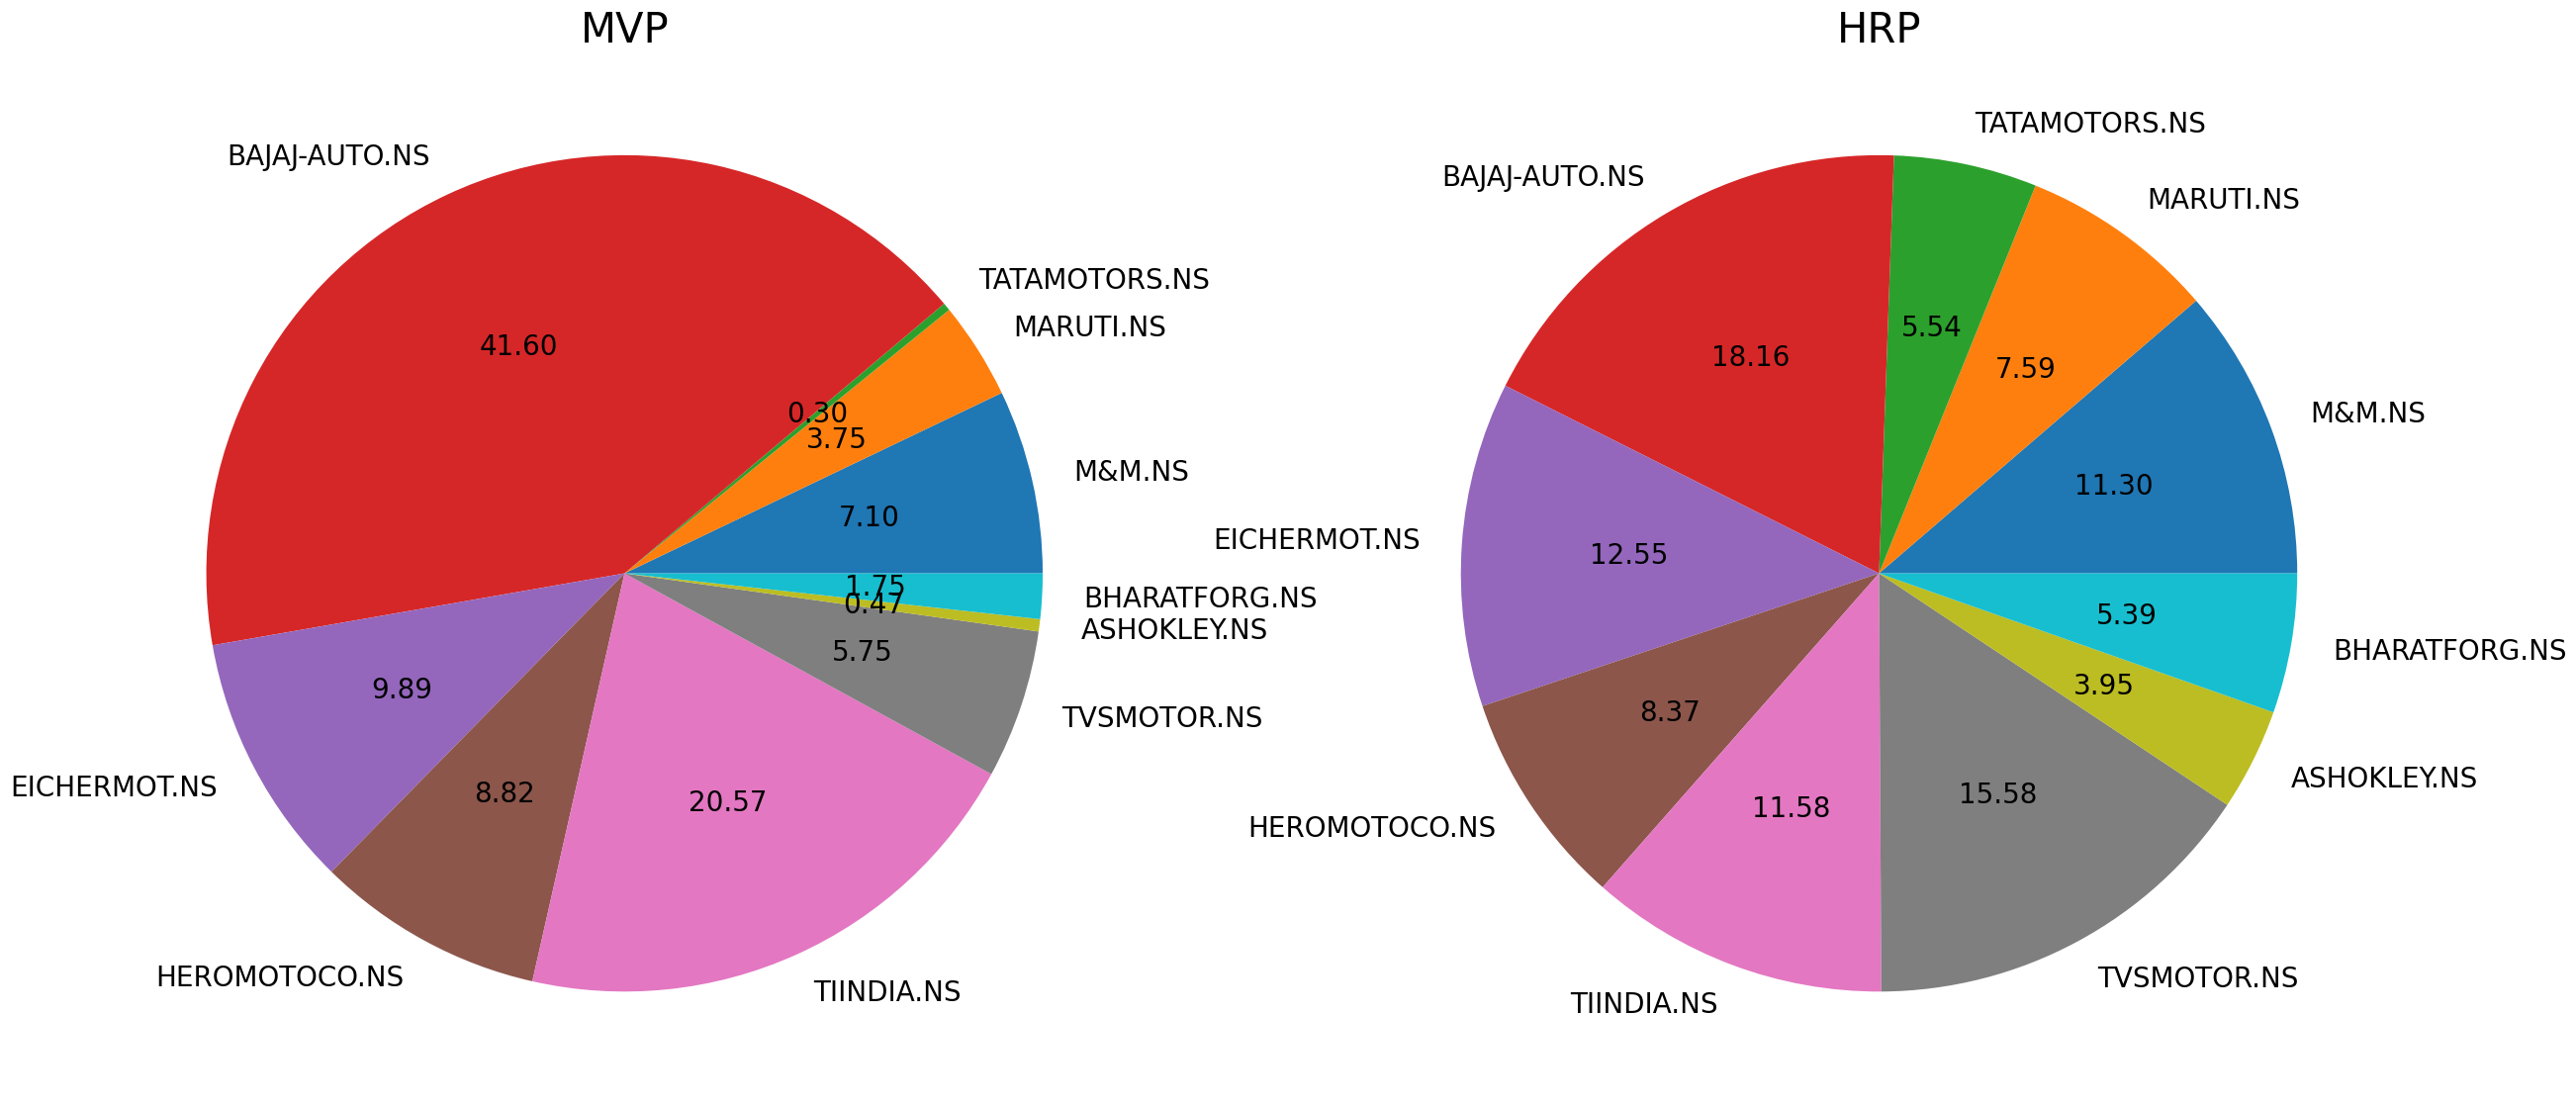

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [27]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

M&M.NS           0.071018
MARUTI.NS        0.037504
TATAMOTORS.NS    0.003022
BAJAJ-AUTO.NS    0.415963
EICHERMOT.NS     0.098945
HEROMOTOCO.NS    0.088170
TIINDIA.NS       0.205688
TVSMOTOR.NS      0.057490
ASHOKLEY.NS      0.004732
BHARATFORG.NS    0.017467
Name: MVP, dtype: float64

In [28]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

M&M.NS           0.113031
MARUTI.NS        0.075910
TATAMOTORS.NS    0.055371
BAJAJ-AUTO.NS    0.181625
EICHERMOT.NS     0.125466
HEROMOTOCO.NS    0.083688
TIINDIA.NS       0.115769
TVSMOTOR.NS      0.155773
ASHOKLEY.NS      0.039462
BHARATFORG.NS    0.053905
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios

### 5.1 Cumulative Returns - Training and Test Data

In [29]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: ylabel='Return'>

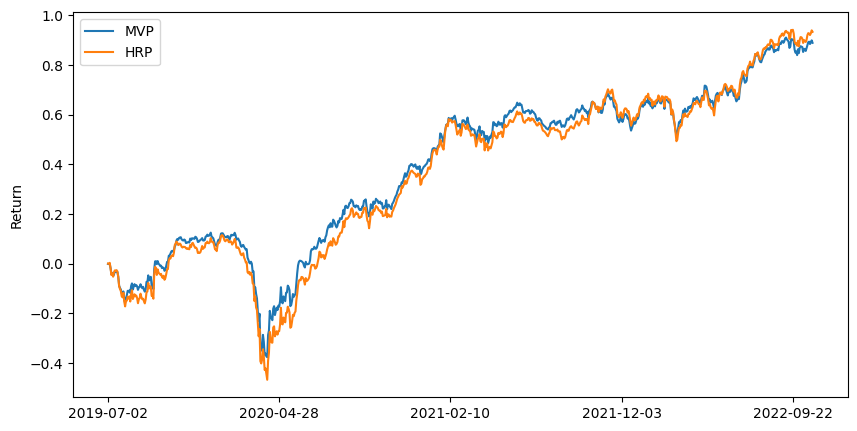

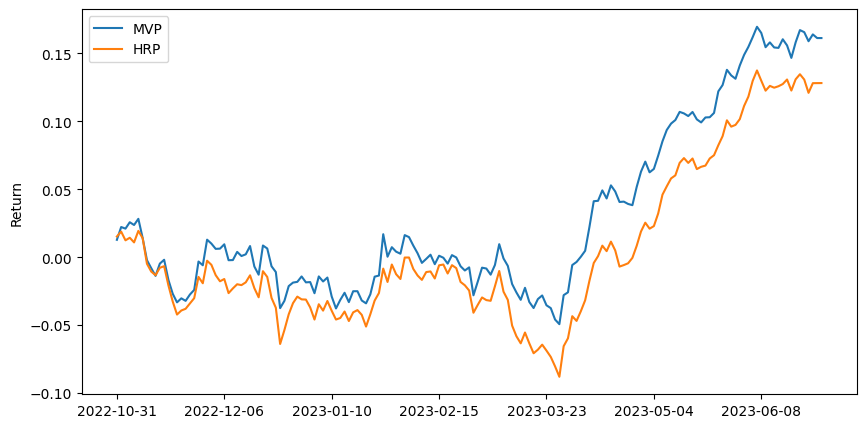

In [30]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [31]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.271896
HRP    0.285424
dtype: float64

In [32]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.246341
HRP    0.195767
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [33]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.248438,1.094419
HRP,0.265452,1.075236


In [34]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.138605,1.777283
HRP,0.131325,1.490700
